In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 80s 0us/step


In [16]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


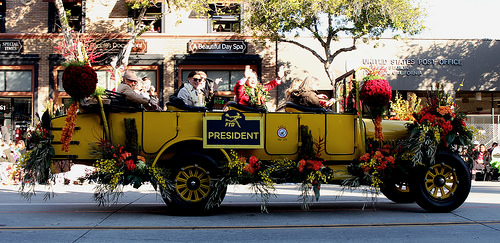

In [17]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

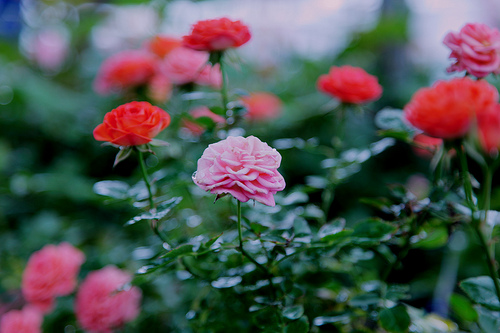

In [18]:
PIL.Image.open(str(roses[1]))

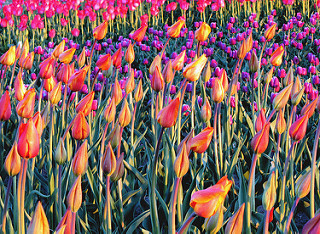

In [19]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

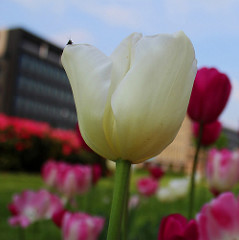

In [20]:
PIL.Image.open(str(tulips[1]))

### 데이터 셋 만들기

In [21]:
batch_size = 32
img_height = 180
img_width = 180

In [25]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [26]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [27]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### 데이터 시각화

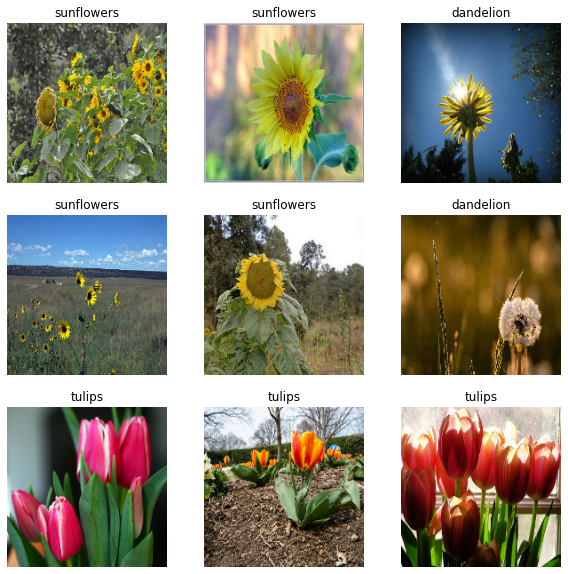

In [43]:
import matplotlib.pyplot as plt

# 이미지 공간 생성.
plt.figure(figsize=(10, 10))


for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [44]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


### 데이터 성능 옵션

In [45]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 데이터 표준화

In [46]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [47]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### 모델 생성

In [60]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [61]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 22, 22, 64)       

### 모델 훈련

In [63]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2021-09-07 14:38:50.944871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - loss: 1.4011 - accuracy: 0.4016

2021-09-07 14:38:59.225648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 9s 89ms/step - loss: 1.4011 - accuracy: 0.4016 - val_loss: 1.0766 - val_accuracy: 0.5531
Epoch 2/10
92/92 [==============================] - 8s 84ms/step - loss: 0.9862 - accuracy: 0.6066 - val_loss: 0.8099 - val_accuracy: 0.7003
Epoch 3/10
92/92 [==============================] - 7s 79ms/step - loss: 0.7901 - accuracy: 0.7003 - val_loss: 0.6648 - val_accuracy: 0.7616
Epoch 4/10
92/92 [==============================] - 8s 82ms/step - loss: 0.5923 - accuracy: 0.7817 - val_loss: 0.4959 - val_accuracy: 0.8338
Epoch 5/10
92/92 [==============================] - 8s 85ms/step - loss: 0.4053 - accuracy: 0.8546 - val_loss: 0.3553 - val_accuracy: 0.8951
Epoch 6/10
92/92 [==============================] - 8s 83ms/step - loss: 0.2617 - accuracy: 0.9125 - val_loss: 0.2809 - val_accuracy: 0.9319
Epoch 7/10
92/92 [==============================] - 8s 84ms/step - loss: 0.1149 - accuracy: 0.9642 - val_loss: 0.2464 - val_accuracy: 0.9428
Epoch 8/10
92/92 [======

### 시각화

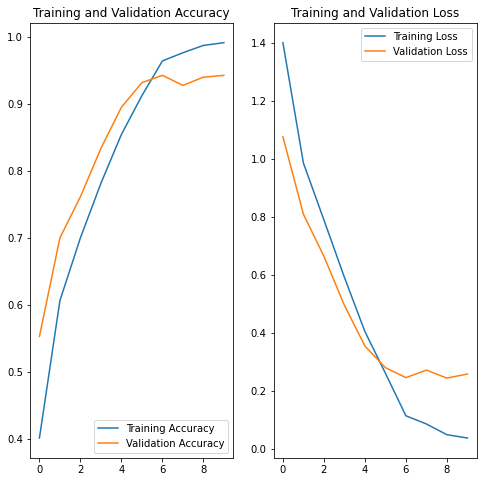

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 드롭 아웃

In [82]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [83]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [84]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 22, 22, 64)      

In [85]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


2021-09-07 14:54:20.189309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - loss: 1.3052 - accuracy: 0.4414

2021-09-07 14:54:27.701985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 8s 88ms/step - loss: 1.3052 - accuracy: 0.4414 - val_loss: 1.0495 - val_accuracy: 0.6035
Epoch 2/15
92/92 [==============================] - 8s 86ms/step - loss: 0.9758 - accuracy: 0.6202 - val_loss: 0.8576 - val_accuracy: 0.6757
Epoch 3/15
92/92 [==============================] - 8s 85ms/step - loss: 0.7869 - accuracy: 0.6955 - val_loss: 0.6287 - val_accuracy: 0.7738
Epoch 4/15
92/92 [==============================] - 8s 85ms/step - loss: 0.6025 - accuracy: 0.7674 - val_loss: 0.4861 - val_accuracy: 0.8093
Epoch 5/15
92/92 [==============================] - 8s 87ms/step - loss: 0.3830 - accuracy: 0.8583 - val_loss: 0.3690 - val_accuracy: 0.8978
Epoch 6/15
92/92 [==============================] - 8s 85ms/step - loss: 0.2184 - accuracy: 0.9271 - val_loss: 0.3159 - val_accuracy: 0.9155
Epoch 7/15
92/92 [==============================] - 8s 86ms/step - loss: 0.1309 - accuracy: 0.9598 - val_loss: 0.3993 - val_accuracy: 0.8842
Epoch 8/15
92/92 [======

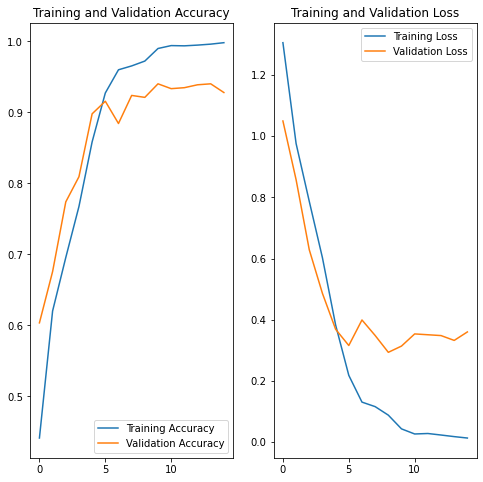

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [192]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 95.60 percent confidence.
